In [1]:
%matplotlib inline

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

"""
    df: dataframe
    vec: Object that convert a collection of text documents to a matrix of token counts
    ascending: order creteria
    qty: first n words to return
    
    Return list with all words and their global frequency (all samples)
"""
def get_resume(df, vec, ascending = False, n = None):
    X = vec.fit_transform(df["text"].values)
    feature_names = vec.get_feature_names()

    resume = pd.DataFrame(columns = feature_names, data = X.toarray()).sum()

    if(n):
        return resume.sort_values(ascending = ascending)[:n]

    return resume

In [2]:
df = pd.read_csv("spam.csv", encoding='latin-1')

df.columns = ["sms_type", "text", "2", "3", "4"]

df.drop("2", axis=1, inplace=True)
df.drop("3", axis=1, inplace=True)
df.drop("4", axis=1, inplace=True)

df["text"] = df["text"].str.lower() # Convert to lowercase

In [3]:
df.describe()

,sms_type,text
count,5572,5572
unique,2,5168
top,ham,"sorry, i'll call later"
freq,4825,30


In [4]:
df["sms_type"].value_counts()

ham     4825
spam     747
Name: sms_type, dtype: int64

In [5]:
vec = CountVectorizer(decode_error = 'ignore', stop_words = "english")
spam_resume = get_resume(df[df["sms_type"] == "spam"], vec, n = 25)
spam_resume

free       224
txt        163
ur         144
mobile     127
text       125
stop       121
claim      113
reply      104
www         98
prize       93
just        78
cash        76
won         76
uk          74
150p        71
send        70
new         69
nokia       67
win         64
urgent      63
tone        60
week        60
50          57
contact     56
service     56
dtype: int64

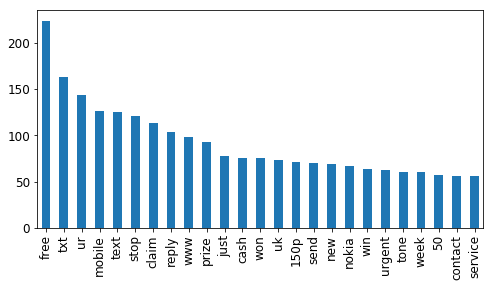

In [6]:
spam_resume.plot(kind = 'bar', figsize = (8, 4), fontsize = 12)

When we work with NLP, it's importat understand the context. Laws are too large and wording is correct and there is no spelling errors. Chats, tweets, text messages, emails (maybe) are very informal nature.
Many times it requires that we inspect texts manually so I did it and I note that spams have phone numbers and urls (check that we have 98 "www" in our sms spams).

In [7]:
df["sms_type"][df["text"].str.contains("\d{4,}")].value_counts()

spam    623
ham      13
Name: sms_type, dtype: int64

Here I use a regular expression to identify urls. You can download from https://github.com/rcompton/ryancompton.net/blob/master/assets/praw_drugs/urlmarker.py (Thanks to John Gruber and Ryan Compton)

In [8]:
WEB_URL_REGEX = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""

df["sms_type"][df["text"].str.contains(WEB_URL_REGEX)].value_counts()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()


spam    134
ham      36
Name: sms_type, dtype: int64

As you can see, that expressions seems to be keeps relation with spams texts, so we will replace them to a fix word


In [9]:
df["text"] = df["text"].str.replace(WEB_URL_REGEX," someurl ")
df["text"] = df["text"].str.replace("\d{4,}"," suspectnumber ")

In [10]:
vec = CountVectorizer(decode_error = 'ignore', stop_words = "english")
spam_resume = get_resume(df[df["sms_type"] == "spam"], vec, n = 25)
spam_resume

suspectnumber    1040
free              224
txt               162
ur                144
someurl           141
mobile            127
text              125
stop              121
claim             113
reply             104
prize              92
just               78
cash               76
won                76
150p               71
nokia              71
send               70
new                69
urgent             63
win                62
week               60
tone               59
50                 57
contact            56
service            56
dtype: int64

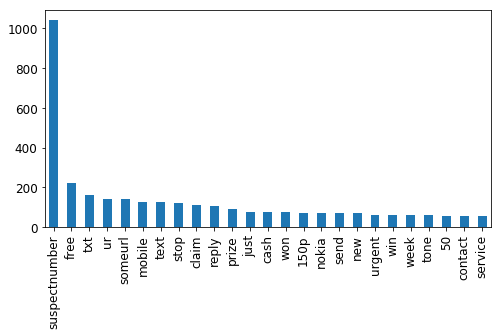

In [11]:
spam_resume.plot(kind = 'bar', figsize = (8, 4), fontsize = 12)

In [12]:
X = df["text"].values
y = df["sms_type"].values
    
folds = StratifiedKFold(n_splits = 5, shuffle = True)
test_scores, train_scores = np.array([]), np.array([])

vocabulary = list(set(list(spam_resume.keys())))

relevant_vec = CountVectorizer(decode_error = 'ignore',
                                stop_words = "english",  
                                vocabulary = vocabulary)

for train_idx, test_idx in folds.split(X, y):

    X_train, y_train = relevant_vec.fit_transform(X[train_idx]), y[train_idx]
    X_test, y_test = relevant_vec.transform(X[test_idx]), y[test_idx]

    log_model = LogisticRegression()
    log_model.fit(X_train, y_train)
    y_pred_test = log_model.predict(X_test)

    c = confusion_matrix(y_test, y_pred_test)
    print(c)
    print("------------------------------")

    train_scores = np.append(train_scores, log_model.score(X_train, y_train))
    test_scores = np.append(test_scores, log_model.score(X_test, y_test))

print(train_scores.mean(), test_scores.mean())

[[956   9]
 [ 16 134]]
------------------------------
[[963   2]
 [ 19 131]]
------------------------------
[[961   4]
 [ 19 130]]
------------------------------
[[963   2]
 [ 14 135]]
------------------------------
[[960   5]
 [ 12 137]]
------------------------------
0.982546697907 0.98169501896


<ul>
    <li> c[0][0] corresponds to True Nagatives -> ham text messages classified as ham (Correctly classified). </li>
    <li> c[0][1] corresponds to False Negatives -> ham text messages classified as spam (wrong classified). </li>
    <li> c[1][0] corresponds to False Positives -> spam text messages classified as ham (wrong classified). </li>
    <li>c[1][1] corresponds to True Positives -> spam text messages classified as spam (Correctly classified). </li>
</ul>

So... as you can see we have a good performance related with ham text messages classification, regarding spam messages we have approximately 10% of misclassification.

If you have any suggestion about how to improve the performace, feel free to comment :)
